In [1]:
# Load packages
library(ggplot2)
library(AER)
library(tidyverse)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: car
Loading required package: carData
Loading required package: lmtest
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: sandwich
Loading required package: survival
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v tibble  2.1.1       v purrr   0.3.2  
v tidyr   0.8.3       v dplyr   0.8.0.1
v readr   1.3.1       v stringr 1.4.0  
v tibble  2.1.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::recode() masks car::recode()
x purrr::some()   m

     dwdiff           rateprdiff     
 Min.   :-12.9032   Min.   :-349.55  
 1st Qu.: -0.3226   1st Qu.:   0.00  
 Median :  0.0000   Median :   0.00  
 Mean   :  2.2422   Mean   :  42.21  
 3rd Qu.:  2.7692   3rd Qu.:   0.00  
 Max.   : 54.4175   Max.   :3287.98  

Saving 13.3 x 13.3 in image


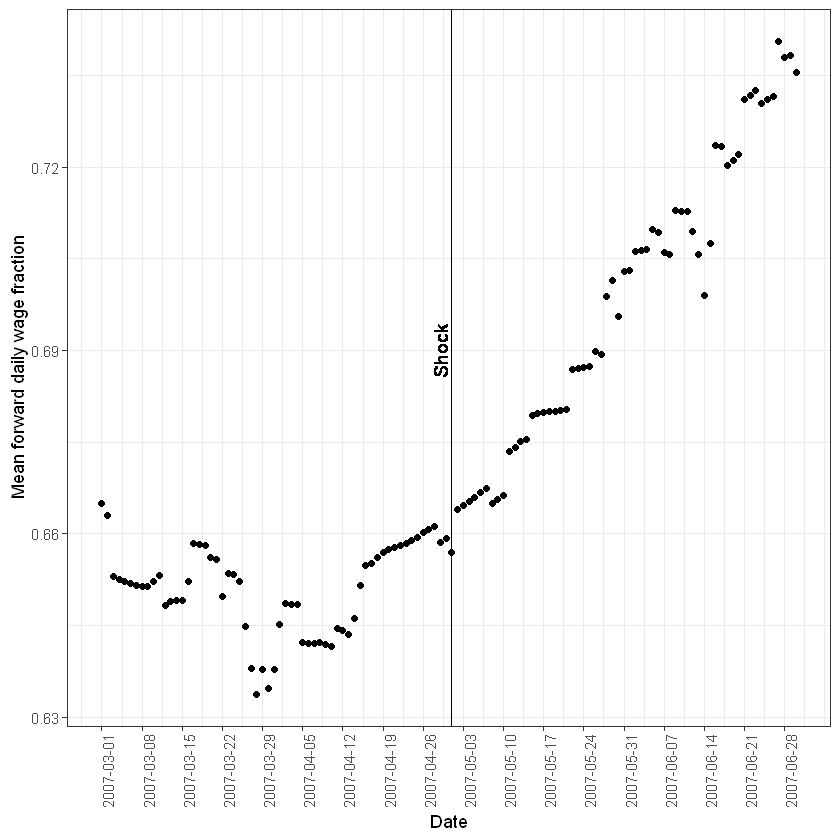

In [2]:
# Load dataset
usedata <- read.csv("data/finalanalysisdata.csv")
diddata <- read.csv("data/didanalysisdata.csv")

# Create a  months since shock variable, and corruption variables
usedata$months_shock <- as.numeric(cut(usedata$day, c(0, 90, 120, 150, 180, 300), c(0, 1, 2, 3, 4)))
usedata$dwdiff <- usedata$daysdwoff - usedata$daysdw
usedata$rateprdiff <- usedata$rateproff - usedata$ratepr

# Check for outliers
summary(usedata[, c("dwdiff", "rateprdiff")])

# Explanations for negative theft values
# Measurement errors.
# Mistake made by the official

# Calculate Correlation table to find potential problems in data
varvec <- c("daysdwoff", "daysdw", "rateproff", "ratepr", "dwdiff", "rateprdiff", "fdwfrac", "bdwfrac", "shock", "day", "dayofmonth")

cor_table = round(cor(usedata[, varvec], use = "pairwise.complete.obs"), 3)

# Replace lower values with empty cells
cor_table[lower.tri(cor_table)] = ""

cor_table <- data.frame(cor_table)

# Publication ready tables
varnames <- c("Off. DW days", "Act. DW days", "Off. rate PR", "Act. rate PR", "DW Diff.", "Rate PR diff", 
              "Forw. fraction DW", "Backw. fraction DW", "Shock", "Day", "Day of Month")

row.names(cor_table) <- varnames
colnames(cor_table) <- varnames

# Save table
write.csv(cor_table, file = "Robustness/tables/CorTable.csv")

# Paper claims no effect of shock and day. However show this
agg_fdwfrac = data.frame("mean_fwddwfrac" = tapply(usedata[, "fdwfrac"], usedata[, "day"], mean, na.rm = TRUE))

# Change names to actual dates
agg_fdwfrac$Date <- as.Date(as.numeric(rownames(agg_fdwfrac)) - 1, origin = "2007-01-01")

# Plot data
ggplot(agg_fdwfrac, aes(x = as.numeric(rownames(agg_fdwfrac)), y = mean_fwddwfrac)) + geom_point() + theme_bw() + geom_vline(xintercept = 121) + 
scale_x_continuous(seq(60, 182, 7), name = "Date", labels = agg_fdwfrac$Date[seq(1, 122, 7)]) + xlab("Date") + ylab("Mean forward daily wage fraction") + theme(axis.text.x = element_text(angle = 90)) + 
  geom_text(aes(x = 119, y = 0.69, label = "Shock"), angle = 90, size = 4, col = "black")

# Save plot
ggsave("Robustness/figures/Fdwfrac.png", scale = 2)

Warning message:
"Removed 1439 rows containing non-finite values (stat_bin)."Saving 13.3 x 13.3 in image
Warning message:
"Removed 1439 rows containing non-finite values (stat_bin)."

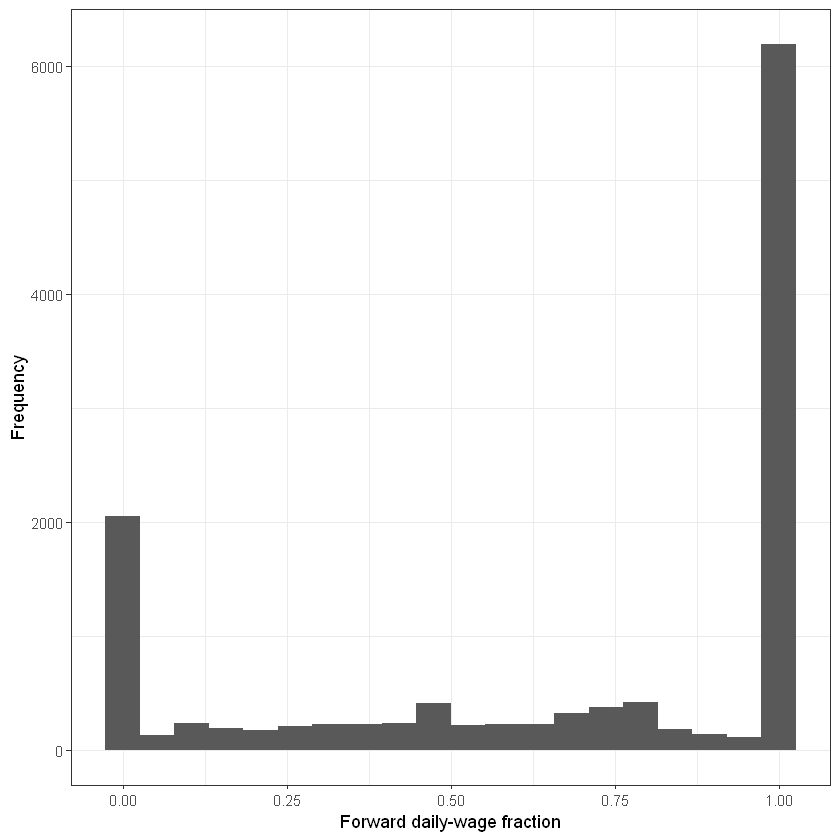

Saving 13.3 x 13.3 in image


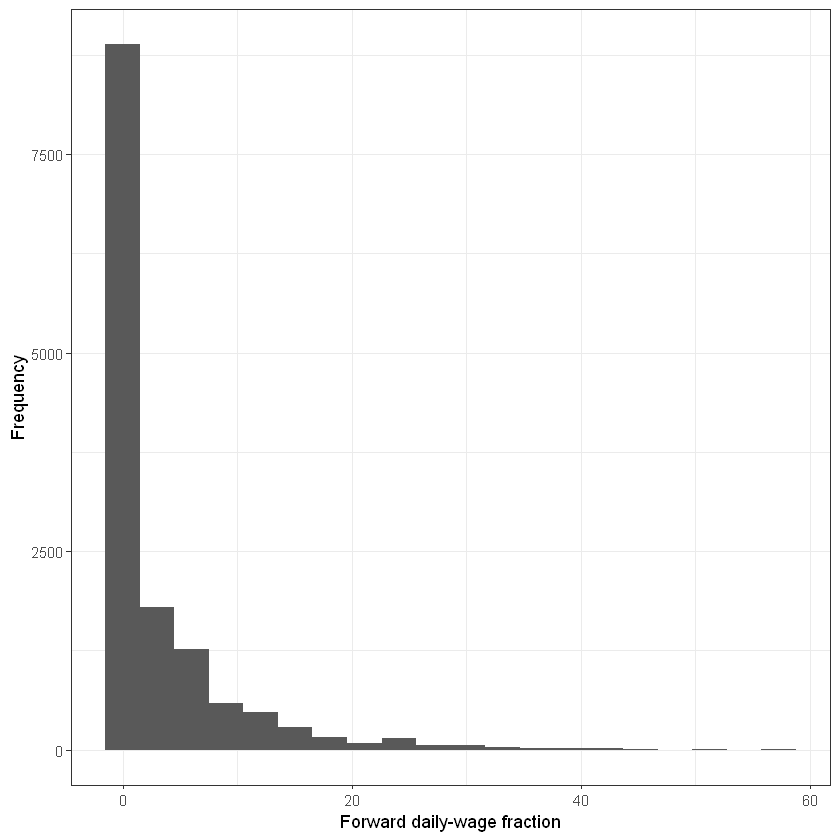

Saving 13.3 x 13.3 in image


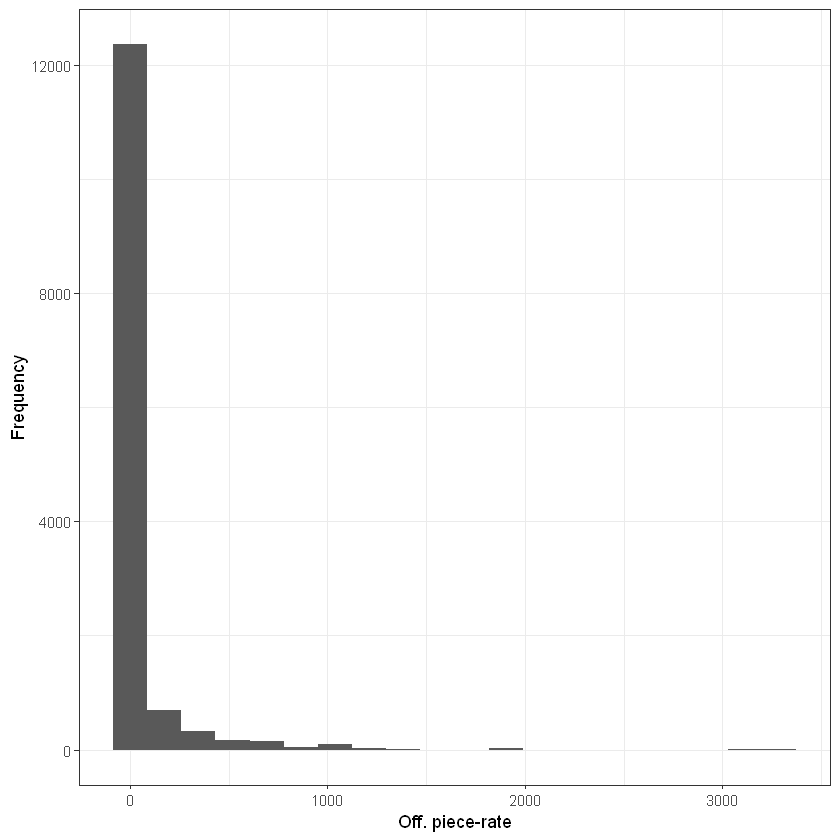

In [3]:
# Motivation for using tobit
# Fdwfrac
ggplot(usedata, aes(x = fdwfrac)) + geom_histogram(bins = 20) + theme_bw() + xlab("Forward daily-wage fraction") + ylab("Frequency")
ggsave("Robustness/figures/Hist_fdwfrac.png", scale = 2)

# Days DW
ggplot(usedata, aes(x = daysdwoff)) + geom_histogram(bins = 20) + theme_bw() + xlab("Forward daily-wage fraction") + ylab("Frequency")
ggsave("Robustness/figures/Hist_daysdw.png", scale = 2)

# Piece rate
ggplot(usedata, aes(x = rateproff)) + geom_histogram(bins = 20) + theme_bw() + xlab("Off. piece-rate") + ylab("Frequency")
ggsave("Robustness/figures/Hist_rateproff.png", scale = 2)

In [4]:
# Regression results
# Load table function
source("Robustness/functions/results.R")

In [5]:
# Table 2 tobit
tobit_t21 = tobit(fdwfrac ~ shock + day + as.factor(did) + holiday + res_gender + res_sbc + res_tribe + season1 + season2 + cluster(upid) + cluster(day), 0, 1, data = usedata)
tobit_t22 = tobit(fdwfrac ~ shock + day + as.factor(did) + holiday + res_gender + res_sbc + res_tribe + season1 + season2 + cluster(ubid) + cluster(day), 0, 1, data = usedata)
tobit_t23 = tobit(fdwfrac ~ shock + day + ubid + holiday + res_gender + res_sbc + res_tribe + season1 + season2 + cluster(ubid) + cluster(day), 0, 1, data = usedata) # Add block FE

# Save output
Table2 <- results(list(tobit_t21, tobit_t22, tobit_t23), c("shock", "day"), 4, 2, T, c("Day", "Day", "Day"), c("District", "District", "Block"), T, c("Shock", "Day"))
write.csv(Table2, "Robustness/tables/Table2.csv")


In [6]:
# Table 3 a)
tobit_32a = tobit(daysdwoff ~ daysdw + shock + day + as.factor(did) + holiday + res_gender + res_sbc + res_tribe + season1 + season2 + dayofmonth
                              + cluster(upid) + cluster(day), 0, data = usedata)

# Cluster by block
tobit_32ab = tobit(daysdwoff ~ daysdw + shock + day + as.factor(did) + holiday + res_gender + res_sbc + res_tribe + season1 + season2 + dayofmonth
                              + cluster(ubid) + cluster(day), 0, data = usedata)

# Block FE
tobit_32ac = tobit(daysdwoff ~ daysdw + shock + day + ubid + holiday + res_gender + res_sbc + res_tribe + season1 + season2 + dayofmonth
                              + cluster(ubid) + cluster(day), 0, data = usedata)

# column 6
tobit_36a = tobit(daysdwoff  ~ daysdw + shock + shock_alwaysdw + alwaysdw
                              + day + shock_day + as.factor(did)
                              + holiday + res_gender + res_sbc + res_tribe + season1 + season2
                              + cluster(upid) + cluster(day), 0, data = usedata)

# Adjust coefficient
# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_36a$coefficients) == "shock")
shock_day_ind <- which(names(tobit_36a$coefficients) == "shock_day")
tobit_36a$coefficients["shock"] <- tobit_36a$coefficients["shock"] + tobit_36a$coefficients["shock_day"]*121
tobit_36a$var[shock_ind, shock_ind] <- tobit_36a$var[shock_ind, shock_ind] + 121*121*tobit_36a$var[shock_day_ind, shock_day_ind] + 2*121*tobit_36a$var[shock_ind, shock_day_ind]

# Cluster by block
tobit_36ab = tobit(daysdwoff  ~ daysdw + shock + shock_alwaysdw + alwaysdw
                              + day + shock_day + as.factor(did)
                              + holiday + res_gender + res_sbc + res_tribe + season1 + season2
                              + cluster(ubid) + cluster(day), 0, data = usedata)

# Adjust coefficient
tobit_36ab$coefficients["shock"] <- tobit_36ab$coefficients["shock"] + tobit_36ab$coefficients["shock_day"]*121

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_36ab$coefficients) == "shock")
shock_day_ind <- which(names(tobit_36ab$coefficients) == "shock_day")
tobit_36ab$var[shock_ind,shock_ind] <- tobit_36ab$var[shock_ind,shock_ind] + 121*121*tobit_36ab$var[shock_day_ind,shock_day_ind] + 2*121*tobit_36ab$var[shock_ind,shock_day_ind]


# Add block FE
tobit_36ac = tobit(daysdwoff  ~ daysdw + shock + shock_alwaysdw + alwaysdw
                              + day + shock_day + ubid
                              + holiday + res_gender + res_sbc + res_tribe + season1 + season2
                              + cluster(ubid) + cluster(day), 0, data = usedata)

# Adjust coefficient
tobit_36ac$coefficients["shock"] <- tobit_36ac$coefficients["shock"] + tobit_36ac$coefficients["shock_day"]*121

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_36ac$coefficients) == "shock")
shock_day_ind <- which(names(tobit_36ac$coefficients) == "shock_day")
tobit_36ac$var[shock_ind,shock_ind] <- tobit_36ac$var[shock_ind,shock_ind] + 121*121*tobit_36ac$var[shock_day_ind,shock_day_ind] + 2*121*tobit_36ac$var[shock_ind,shock_day_ind]

# Save Regression Outputs
Table3a <- results(list(tobit_32a, tobit_32ab, tobit_32ac, tobit_36a, tobit_36ab, tobit_36ac), c("shock", "shock_alwaysdw", "alwaysdw"), 2, 2, T, 
                   TE = c("Day", "Day", "Day", "Shock x Day", "Shock x Day", "Shock x Day"), 
                   FE = c("District", "District", "Block", "District", "District", "Block"), 
                   labels = c("Shock", "Shock x (Always DW)", "Always DW"))
write.csv(Table3a, "Robustness/tables/Table3a.csv")

In [7]:
# Table 3 b)
tobit_32b = tobit(daysdwoff ~ daysdw + shock + shock_fdw_all + shock_fdw_some + fdw_all + fdw_some
                              + holiday + res_gender + res_sbc + res_tribe + day + as.factor(did)
                              + season1 + season2 + dayofmonth + cluster(upid) + cluster(day), 0, data = usedata)

# Cluster by block
tobit_32bb = tobit(daysdwoff ~ daysdw + shock + shock_fdw_all + shock_fdw_some + fdw_all + fdw_some
                              + holiday + res_gender + res_sbc + res_tribe + day + as.factor(did)
                              + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day), 0, data = usedata)

# Block FE
tobit_32bc = tobit(daysdwoff ~ daysdw + shock + shock_fdw_all + shock_fdw_some + fdw_all + fdw_some
                              + holiday + res_gender + res_sbc + res_tribe + day + ubid
                              + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day), 0, data = usedata)

tobit_36b = tobit(daysdwoff  ~  daysdw + shock + shock_fdw_all + shock_fdw_some + shock_bdw_all + shock_bdw_some + fdw_all + fdw_some + bdw_all + bdw_some
                              + holiday + res_gender + res_sbc + res_tribe + day + shock_day + as.factor(did)
                              + season1 + season2 + dayofmonth + cluster(upid) + cluster(day), 0, data = usedata)

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_36b$coefficients) == "shock")
shock_day_ind <- which(names(tobit_36b$coefficients) == "shock_day")

# Adjusting shock coefficient
tobit_36b$coefficients[shock_ind] <- tobit_36b$coefficients[shock_ind] + tobit_36b$coefficients[shock_day_ind]*121
tobit_36b$var[shock_ind,shock_ind] <- tobit_36b$var[shock_ind,shock_ind] + 121*121*tobit_36b$var[shock_day_ind,shock_day_ind] + 2*121*tobit_36b$var[shock_ind,shock_day_ind]

# Cluster by block
tobit_36bb = tobit(daysdwoff  ~  daysdw + shock + shock_fdw_all + shock_fdw_some + shock_bdw_all + shock_bdw_some + fdw_all + fdw_some + bdw_all + bdw_some
                              + holiday + res_gender + res_sbc + res_tribe + day + shock_day + as.factor(did)
                              + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day), 0, data = usedata)

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_36bb$coefficients) == "shock")
shock_day_ind <- which(names(tobit_36bb$coefficients) == "shock_day")

# ADjusting shock coefficient
tobit_36bb$coefficients[shock_ind] <- tobit_36bb$coefficients[shock_ind] + tobit_36bb$coefficients[shock_day_ind]*121

tobit_36bb$var[shock_ind,shock_ind] <- tobit_36bb$var[shock_ind,shock_ind] + 121*121*tobit_36bb$var[shock_day_ind,shock_day_ind] + 2*121*tobit_36bb$var[shock_ind,shock_day_ind]

# Block FE
tobit_36bc = tobit(daysdwoff  ~  daysdw + shock + shock_fdw_all + shock_fdw_some + shock_bdw_all + shock_bdw_some + fdw_all + fdw_some + bdw_all + bdw_some
                              + holiday + res_gender + res_sbc + res_tribe + day + shock_day + ubid
                              + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day), 0, data = usedata)

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_36bc$coefficients) == "shock")
shock_day_ind <- which(names(tobit_36bc$coefficients) == "shock_day")

# ADjusting shock coefficient
tobit_36bc$coefficients[shock_ind] <- tobit_36bc$coefficients[shock_ind] + tobit_36bc$coefficients[shock_day_ind]*121

tobit_36bc$var[shock_ind,shock_ind] <- tobit_36bc$var[shock_ind,shock_ind] + 121*121*tobit_36bc$var[shock_day_ind,shock_day_ind] + 2*121*tobit_36bc$var[shock_ind,shock_day_ind]

# Save Regression Outputs
Table3b <- results(list(tobit_32b, tobit_32bb, tobit_32bc, tobit_36b, tobit_36bb, tobit_36bc), c("shock", "shock_fdw_all", "shock_fdw_some", "shock_bdw_all", "shock_bdw_some"),
                   2, 2, T, TE = c("Day", "Day", "Day", "Shock x Day", "Shock x Day", "Shock x Day"), 
                   FE = c("District", "District", "Block", "District", "District", "Block"),
                   labels = c("Shock", "Shock x (Forward DW All)", "Shock x (Forward DW Some)", "Shock x (Backward DW All)", "Shock x (Backward DW Some)"))
write.csv(Table3b, "Robustness/tables/Table3b.csv")

In [8]:
# Table 4a
# Column 2
tobit_42a = tobit(rateproff ~ ratepr + shock + day + as.factor(did)  + holiday + res_gender + res_sbc + res_tribe
                               + season1 + season2 + dayofmonth + cluster(upid) + cluster(day), 0, data = usedata)

tobit_42ab = tobit(rateproff ~ ratepr + shock + day + as.factor(did)  + holiday + res_gender + res_sbc + res_tribe
                               + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day), 0, data = usedata)

tobit_42ac = tobit(rateproff ~ ratepr + shock + day + ubid  + holiday + res_gender + res_sbc + res_tribe
                               + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day), 0, data = usedata)

# Column 6
tobit_46a = tobit(rateproff  ~ ratepr + shock + shock_alwayspr + alwayspr + day + shock_day + as.factor(did)  + holiday
                               + res_gender + res_sbc + res_tribe + season1 + season2 + dayofmonth + cluster(upid) + cluster(day),
                               data = usedata)

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_46a$coefficients) == "shock")
shock_day_ind <- which(names(tobit_46a$coefficients) == "shock_day")

# Adjusting Coefficient
tobit_46a$coefficients[shock_ind] <- tobit_46a$coefficients[shock_ind] + tobit_46a$coefficients[shock_day_ind]*121
tobit_46a$var[shock_ind,shock_ind] <- tobit_46a$var[shock_ind,shock_ind] + 121*121*tobit_46a$var[shock_day_ind,shock_day_ind] + 2*121*tobit_46a$var[shock_ind,shock_day_ind]

# Block level FE
tobit_46ab = tobit(rateproff  ~ ratepr + shock + shock_alwayspr + alwayspr + day + shock_day + as.factor(did)  + holiday
                               + res_gender + res_sbc + res_tribe + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day),
                               data = usedata)

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_46ab$coefficients) == "shock")
shock_day_ind <- which(names(tobit_46ab$coefficients) == "shock_day")

# Adjusting coefficient 
tobit_46ab$coefficients[shock_ind] <- tobit_46ab$coefficients[shock_ind] + tobit_46ab$coefficients[shock_day_ind]*121
tobit_46ab$var[shock_ind,shock_ind] <- tobit_46ab$var[shock_ind,shock_ind] + 121*121*tobit_46ab$var[shock_day_ind,shock_day_ind] + 2*121*tobit_46ab$var[shock_ind,shock_day_ind]

# Block level FE
tobit_46ac = tobit(rateproff  ~ ratepr + shock + shock_alwayspr + alwayspr + day + shock_day + ubid  + holiday
                               + res_gender + res_sbc + res_tribe + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day),
                               data = usedata)

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_46ac$coefficients) == "shock")
shock_day_ind <- which(names(tobit_46ac$coefficients) == "shock_day")

# Adjusting coefficient 
tobit_46ac$coefficients[shock_ind] <- tobit_46ac$coefficients[shock_ind] + tobit_46ac$coefficients[shock_day_ind]*121
tobit_46ac$var[shock_ind,shock_ind] <- tobit_46ac$var[shock_ind,shock_ind] + 121*121*tobit_46ac$var[shock_day_ind,shock_day_ind] + 2*121*tobit_46ac$var[shock_ind,shock_day_ind]

# Save Table 4a. Controlling for Blocks made the system unsolvable
Table4a <- results(list(tobit_42a, tobit_42ab, tobit_46a, tobit_46ab), c("shock", "shock_alwayspr", "alwayspr"), 
                   TE = c("Day", "Day", "Shock x Day", "Shock x Day"),
                   FE = c("District", "District", "District", "District"),
                   labels = c("Shock", "Shock x (Always PR)", "Always PR"))
write.csv(Table4a, "Robustness/tables/Table4a.csv")

In [9]:
# Panel B: Dynamic effects
tobit_42b = tobit(rateproff  ~ ratepr + shock + shock_fdw_all + shock_fdw_some + fdw_all + fdw_some + holiday + res_gender + res_sbc + res_tribe
                              + day + as.factor(did) + season1 + season2 + dayofmonth + cluster(upid) + cluster(day), data = usedata)

# Cluster by block
tobit_42bb = tobit(rateproff  ~ ratepr + shock + shock_fdw_all + shock_fdw_some + fdw_all + fdw_some + holiday + res_gender + res_sbc + res_tribe
                              + day + as.factor(did) + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day), data = usedata)

# Block FE
tobit_42bc = tobit(rateproff  ~ ratepr + shock + shock_fdw_all + shock_fdw_some + fdw_all + fdw_some + holiday + res_gender + res_sbc + res_tribe
                              + day + ubid + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day), data = usedata)

# Column 6
tobit_46b <- tobit(rateproff  ~ ratepr + shock + shock_fdw_all + shock_fdw_some + shock_bdw_all + shock_bdw_some + fdw_all + fdw_some
                            + bdw_all + bdw_some  + holiday + res_gender + res_sbc + res_tribe + day + shock_day + as.factor(did)
                            + season1 + season2 + dayofmonth + cluster(upid) + cluster(day), 0, 
                            data = usedata)

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_46b$coefficients) == "shock")
shock_day_ind <- which(names(tobit_46b$coefficients) == "shock_day")

# Adjusting Shock effect
tobit_46b$coefficients[shock_ind] <- tobit_46b$coefficients[shock_ind] + tobit_46b$coefficients[shock_day_ind]*121
tobit_46b$var[shock_ind,shock_ind] <- tobit_46b$var[shock_ind,shock_ind] + 121*121*tobit_46b$var[shock_day_ind,shock_day_ind] + 2*121*tobit_46b$var[shock_ind,shock_day_ind]

# Clustering by block
tobit_46bb <- tobit(rateproff  ~ ratepr + shock + shock_fdw_all + shock_fdw_some + shock_bdw_all + shock_bdw_some + fdw_all + fdw_some
                                + bdw_all + bdw_some  + holiday + res_gender + res_sbc + res_tribe + day + shock_day + as.factor(did)
                                + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day), 0, 
                                data = usedata)

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_46bb$coefficients) == "shock")
shock_day_ind <- which(names(tobit_46bb$coefficients) == "shock_day")

# Adjusting Shock effect
tobit_46bb$coefficients[shock_ind] <- tobit_46bb$coefficients[shock_ind] + tobit_46bb$coefficients[shock_day_ind]*121
tobit_46bb$var[shock_ind,shock_ind] <- tobit_46bb$var[shock_ind,shock_ind] + 121*121*tobit_46bb$var[shock_day_ind,shock_day_ind] + 2*121*tobit_46bb$var[shock_ind,shock_day_ind]

# Adding block FE
tobit_46bc <- tobit(rateproff  ~ ratepr + shock + shock_fdw_all + shock_fdw_some + shock_bdw_all + shock_bdw_some + fdw_all + fdw_some
                                + bdw_all + bdw_some  + holiday + res_gender + res_sbc + res_tribe + day + shock_day + ubid
                                + season1 + season2 + dayofmonth + cluster(ubid) + cluster(day), 0, 
                                data = usedata)

# Need to find numeric index of shock and shock_day
shock_ind <- which(names(tobit_46bc$coefficients) == "shock")
shock_day_ind <- which(names(tobit_46bc$coefficients) == "shock_day")

# Adjusting Shock effect
tobit_46bc$coefficients[shock_ind] <- tobit_46bc$coefficients[shock_ind] + tobit_46bc$coefficients[shock_day_ind]*121
tobit_46bc$var[shock_ind,shock_ind] <- tobit_46bc$var[shock_ind,shock_ind] + 121*121*tobit_46bc$var[shock_day_ind,shock_day_ind] + 2*121*tobit_46bc$var[shock_ind,shock_day_ind]

# Write Table 4b. Block FE not solvable
Table4b <- results(list(tobit_42b, tobit_42bb, tobit_46b, tobit_46bb), c("shock", "shock_fdw_all", "shock_fdw_some", "shock_bdw_all", "shock_bdw_some"),
                   2, 2, T, TE = c("Day", "Day", "Shock x Day", "Shock x Day"),
                   FE = c("District", "District", "District", "District"),
                   labels = c("Shock", "Shock x (Forward DW All)", "Shock x (Forward DW Some)", "Shock x (Backward DW All)", "Shock x (Backward DW Some)"))
write.csv(Table4b, "Robustness/tables/Table4b.csv")

Saving 13.3 x 13.3 in image


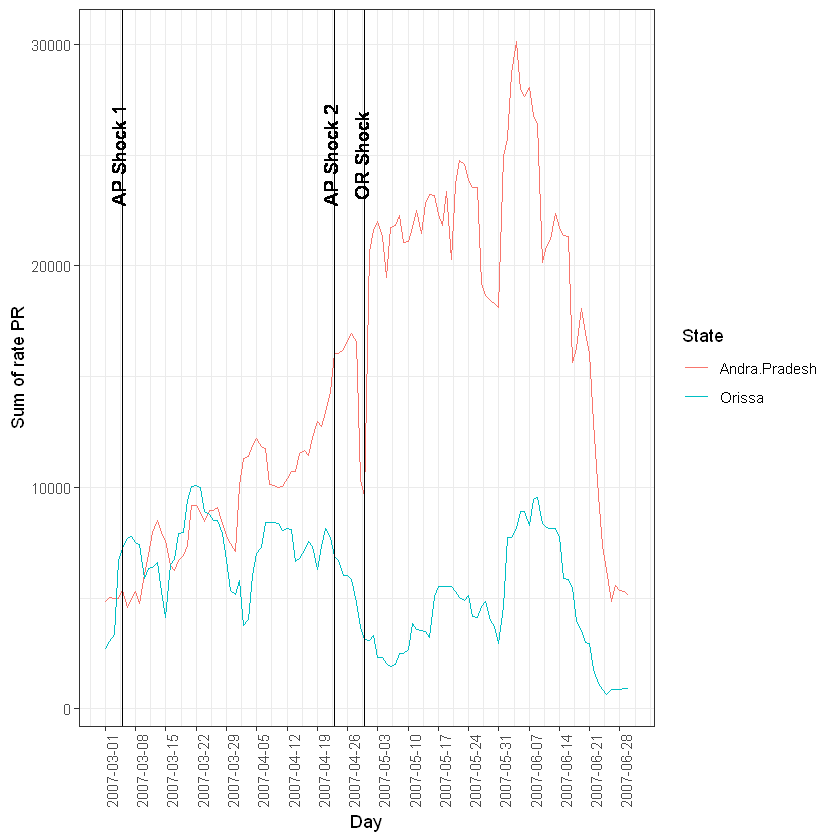

Saving 13.3 x 13.3 in image


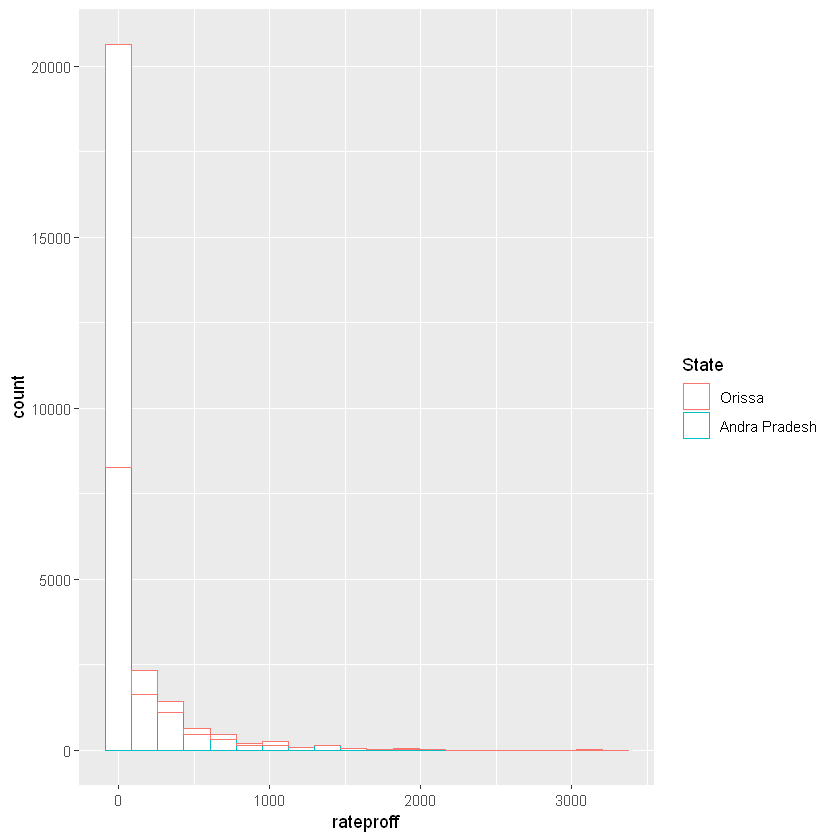

In [10]:
# Assessing did-Assumptions
did_assump = t(tapply((diddata$rateproff), list(diddata$sid, diddata$day), sum, na.rm = TRUE, simplify = TRUE))
colnames(did_assump) <- c("Orissa", "Andra Pradesh")

# Bring into single column form
did_assump <- gather(data.frame(did_assump), "State", "SumPRoff")

# Generate Day column
did_assump$day <- rep(1:122, 2)

# Plot
ggplot(did_assump, aes(x = day, y = SumPRoff, col = State)) + geom_line() + theme_bw() + labs(x = "Day", y = "Sum of rate PR") + geom_vline(xintercept = c(5, 54, 61)) +
  scale_x_continuous(breaks = seq(1, 122, 7), labels = as.Date(did_assump$day - 1, origin = "2007-03-01")[seq(1, 122, 7)]) + theme(axis.text.x = element_text(angle = 90)) +
  geom_text(aes(x = 60, y = 25000, label = "OR Shock"), angle = 90, col = "black", size = 4) + 
  geom_text(aes(x = 53, y = 25000, label = "AP Shock 2"), angle = 90, col = "black", size = 4) + 
  geom_text(aes(x = 4, y = 25000, label = "AP Shock 1"), angle = 90, col = "black", size = 4)

# Save image 
ggsave("Robustness/figures/Did_assump.png", scale = 2)

# Histogram of rateproff by states
diddata$State <- factor(diddata$sid, levels = c(24, 99), labels = c("Orissa", "Andra Pradesh"))
ggplot(diddata, aes(x = rateproff)) + geom_histogram(aes(col = State), bins = 20, fill = "white")

ggsave("Robustness/figures/Hist_rateproff_ORAP.png", scale = 2)

In [11]:
# DiD assumption doesn't hold. Replicate using Tobit
tobit_51a = tobit(rateproff ~ orshock + or_orshock + apshock1 + ap_apshock1 + apshock2 + ap_apshock2
                              + day + ratepr + holiday + season1 + season2 + dayofmonth + as.factor(sid)
                              + cluster(upid) + cluster(day), data = diddata)

# District FE
tobit_52a = tobit(rateproff ~ orshock + or_orshock + apshock1 + ap_apshock1 + apshock2 + ap_apshock2
                              + day + ratepr  + holiday + season1 + season2 + dayofmonth + as.factor(did)
                              + cluster(upid) + cluster(day), data = diddata)

# DID and district FE
tobit_53a = tobit(rateproff ~ orshock + or_orshock + apshock1 + ap_apshock1 + apshock2 + ap_apshock2
                              + day + shock_day + ratepr  + holiday + season1 + season2 + dayofmonth + as.factor(did)
                              + cluster(upid) + cluster(day), data = diddata)

# Need to find numeric index of shock and shock_day
orshock_ind <- which(names(tobit_53a$coefficients) == "orshock")
shock_day_ind <- which(names(tobit_53a$coefficients) == "shock_day")

# Adjusting effect
tobit_53a$coefficients[orshock_ind] <- tobit_53a$coefficients[orshock_ind] + tobit_53a$coefficients[shock_day_ind]*121
tobit_53a$var[orshock_ind,orshock_ind] <- tobit_53a$var[orshock_ind,orshock_ind] + 121*121*tobit_53a$var[shock_day_ind,shock_day_ind] + 2*121*tobit_53a$var[orshock_ind,shock_day_ind]

# UBID instead of did
tobit_53ab = tobit(rateproff ~ orshock + or_orshock + apshock1 + ap_apshock1 + apshock2 + ap_apshock2
                              + day + shock_day + ratepr  + holiday + season1 + season2 + dayofmonth + as.factor(did)
                              + cluster(ubid) + cluster(day), data = diddata)

# Need to find numeric index of shock and shock_day
orshock_ind <- which(names(tobit_53ab$coefficients) == "orshock")
shock_day_ind <- which(names(tobit_53ab$coefficients) == "shock_day")

# Adjusting effect
tobit_53ab$coefficients[orshock_ind] <- tobit_53ab$coefficients[orshock_ind] + tobit_53ab$coefficients[shock_day_ind]*121
tobit_53ab$var[orshock_ind,orshock_ind] <- tobit_53ab$var[orshock_ind,orshock_ind] + 121*121*tobit_53ab$var[shock_day_ind,shock_day_ind] + 2*121*tobit_53ab$var[orshock_ind,shock_day_ind]

# Output Table
Table5 <- results(list(tobit_51a, tobit_52a, tobit_53a, tobit_53ab), 
                  c("or_orshock", "ap_apshock1", "ap_apshock2", "orshock", "apshock1", "apshock2", "ratepr"),
                  TE = c("Day", "Day", "Shock x Day", "Shock x Day"), FE = c("State", "District", "District", "District"),
                  labels = c("OR x (OR Shock)", "AP x (AP Shock 1)", "AP x (AP Shock 2)", "OR Shock", "AP Shock 1", "AP Shock 2", "Actual PR payments"))
write.csv(Table5, "Robustness/tables/Table5.csv")